# Solucion de la tarea 3
## Módulo 4 - Big Data
## Estudidante: Yoksan Varela Cambronero

In [1]:
# Librerias generales
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Informacion del set de datos, carga y explicacion de los atributos

En esta tarea se plantea una solucion con aprendizaje automatico con la cual se plantea predecir si un animal de un refugio va a ser adoptado o no.

El set de datos a utilizar se llama pet_adoption_data.csv del post *Predict Pet Adoption Status Dataset* (URL: https://www.kaggle.com/datasets/rabieelkharoua/predict-pet-adoption-status-dataset). A continuacion de procede a cargar el CSV en un dataframe explicar las columnas del mismo.

In [2]:
# Cargar el conjunto de datos completo. Este paso no realiza ningún ajuste; simplemente lectura
import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType, BooleanType)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

df_pets_raw = spark \
    .read \
    .format("csv") \
    .option("path", "./datasets/pet_adoption_data.csv") \
    .option("header", False) \
    .schema(StructType([
                StructField("pet_id", IntegerType()),           # El ID del animal
                StructField("pet_type", StringType()),          # El tipo del animal
                StructField("breed", StringType()),             # La raza del mismo
                StructField("age_months", IntegerType()),       # Edad del animal en meses
                StructField("color", StringType()),             # Color del animal
                StructField("size", StringType()),              # Tamanno del mismo
                StructField("weight_kg", FloatType()),          # Masa del animal en kilogramos
                StructField("vaccinated", StringType()),       # Indicador si el animal ha sido vacunado o no
                StructField("health_condition", StringType()), # Indicador si es saludable o tiene algun problema de salud
                StructField("days_in_shelter", IntegerType()),  # Cantidad de dias que el animal ha estado en el refugio
                StructField("adoption_fee", IntegerType()),     # Cantidad dolares a pagar por el animal
                StructField("previous_owner", StringType()),   # Indicador si el animal tuvo un dueno antes o no
                StructField("adoption_status", StringType())])).load() # Indicador si el animal fue adoptado o no

df_pets_raw.printSchema()
df_pets_raw.show()

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/07 23:34:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


root
 |-- pet_id: integer (nullable = true)
 |-- pet_type: string (nullable = true)
 |-- breed: string (nullable = true)
 |-- age_months: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- size: string (nullable = true)
 |-- weight_kg: float (nullable = true)
 |-- vaccinated: string (nullable = true)
 |-- health_condition: string (nullable = true)
 |-- days_in_shelter: integer (nullable = true)
 |-- adoption_fee: integer (nullable = true)
 |-- previous_owner: string (nullable = true)
 |-- adoption_status: string (nullable = true)

+------+--------+----------------+----------+------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|pet_id|pet_type|           breed|age_months| color|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|
+------+--------+----------------+----------+------+------+---------+----------+----------------+---------------+------------+----

In [3]:
from pyspark.sql.functions import col, when

# Convirtiendo los atributos binarios a BooleanType
# vaccinated
df_pets_transformed = df_pets_raw.withColumn('vaccinated', when(col('vaccinated') == "1", True).when(col('vaccinated') == "0", False).otherwise(None))
df_pets_transformed = df_pets_raw.withColumn('vaccinated', col('vaccinated').cast(BooleanType()))

# health_condition
df_pets_transformed = df_pets_transformed.withColumn('health_condition', when(col('health_condition') == "1", True).when(col('health_condition') == "0", False).otherwise(None))
df_pets_transformed = df_pets_transformed.withColumn('health_condition', col('health_condition').cast(BooleanType()))

# previous_owner
df_pets_transformed = df_pets_transformed.withColumn('previous_owner', when(col('previous_owner') == "1", True).when(col('previous_owner') == "0", False).otherwise(None))
df_pets_transformed = df_pets_transformed.withColumn('previous_owner', col('previous_owner').cast(BooleanType()))

# adoption_status
df_pets_transformed = df_pets_transformed.withColumn('adoption_status', when(col('adoption_status') == "1", True).when(col('adoption_status') == "0", False).otherwise(None))
df_pets_transformed = df_pets_transformed.withColumn('adoption_status', col('adoption_status').cast(BooleanType()))

df_pets_transformed.printSchema()
df_pets_transformed.show()


root
 |-- pet_id: integer (nullable = true)
 |-- pet_type: string (nullable = true)
 |-- breed: string (nullable = true)
 |-- age_months: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- size: string (nullable = true)
 |-- weight_kg: float (nullable = true)
 |-- vaccinated: boolean (nullable = true)
 |-- health_condition: boolean (nullable = true)
 |-- days_in_shelter: integer (nullable = true)
 |-- adoption_fee: integer (nullable = true)
 |-- previous_owner: boolean (nullable = true)
 |-- adoption_status: boolean (nullable = true)

+------+--------+----------------+----------+------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|pet_id|pet_type|           breed|age_months| color|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|
+------+--------+----------------+----------+------+------+---------+----------+----------------+---------------+------------+

**La variable predictiva en este ejercicio es adoption_status**, el cual es 1 si el animal fue adoptado o 0 en el caso contrario. Revisando la presencia de valores NaN en el dataset:

In [4]:
from pyspark.sql.functions import col, sum

nan_counts = df_pets_transformed.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_pets_raw.columns])
nan_counts.show()

+------+--------+-----+----------+-----+----+---------+----------+----------------+---------------+------------+--------------+---------------+
|pet_id|pet_type|breed|age_months|color|size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|
+------+--------+-----+----------+-----+----+---------+----------+----------------+---------------+------------+--------------+---------------+
|     0|       0|    0|         0|    0|   0|        0|         0|               0|              0|           0|             0|              0|
+------+--------+-----+----------+-----+----+---------+----------+----------------+---------------+------------+--------------+---------------+



Se concluye que no hay NaN en el dataset. Se descartan las siguientes columnas:
- **pet_id:** Al ser un indicador unico del animal, no aporta ningun valor al estudio.
- **color:** El color es una variable completamente subjetiva por parte de las personas, asi que podria introducir ruido al estudio.

In [5]:
df_pets_clean = df_pets_transformed.drop('pet_id','color')
df_pets_clean.printSchema()
df_pets_clean.show()

root
 |-- pet_type: string (nullable = true)
 |-- breed: string (nullable = true)
 |-- age_months: integer (nullable = true)
 |-- size: string (nullable = true)
 |-- weight_kg: float (nullable = true)
 |-- vaccinated: boolean (nullable = true)
 |-- health_condition: boolean (nullable = true)
 |-- days_in_shelter: integer (nullable = true)
 |-- adoption_fee: integer (nullable = true)
 |-- previous_owner: boolean (nullable = true)
 |-- adoption_status: boolean (nullable = true)

+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|pet_type|           breed|age_months|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|
+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|    Bird|        Parakeet|       131| Large|5.0397677|      true|           false|   

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


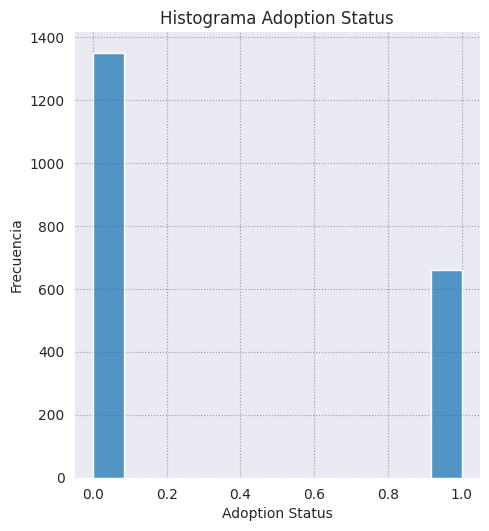

In [6]:
# Analizando el balanceo en el objetivo predictivo
# Estilo de Seaborn
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Hacer collect de la variable predictiva
df_adopt_status = df_pets_clean.select('adoption_status').rdd.flatMap(lambda x: x).collect()

sns.displot(data=df_adopt_status, kde=False)
plt.xlabel('Adoption Status')
plt.ylabel('Frecuencia')
plt.title('Histograma Adoption Status')
plt.show()


In [7]:
# Solucionando el problema de balanceo con un sub-sampleo de las mascotas adoptadas
# Haciendo una cuenta de los valores de adoption_status
class_counts = df_pets_clean.groupBy('adoption_status').count()
class_counts.show()

+---------------+-----+
|adoption_status|count|
+---------------+-----+
|           true|  659|
|          false| 1348|
+---------------+-----+



Hay un problema de balance, en donde hay mas del doble de animales NO adoptados contra los adoptados. Se procede a hacer un balance con un sub-sampleo de los animales adoptados:

In [8]:
# Separando los dos valores
minority_class_df = df_pets_clean.filter(col('adoption_status') == True)
majority_class_df = df_pets_clean.filter(col('adoption_status') == False)

# Calculando la cantidad de subsampleo necesario para que haya balance
min_count = class_counts.agg({"count": "min"}).collect()[0][0]
fraction = min_count / majority_class_df.count()

# Creando un dataframe con el sub-sampleo
undersampled_majority_class_df = majority_class_df.sample(withReplacement=False, fraction=fraction)

# Ahora se combinan los dataframe para generar uno ya balanceado
df_pets_balanced = undersampled_majority_class_df.union(minority_class_df)

df_pets_balanced.groupBy('adoption_status').count().show()

+---------------+-----+
|adoption_status|count|
+---------------+-----+
|          false|  648|
|           true|  659|
+---------------+-----+



<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


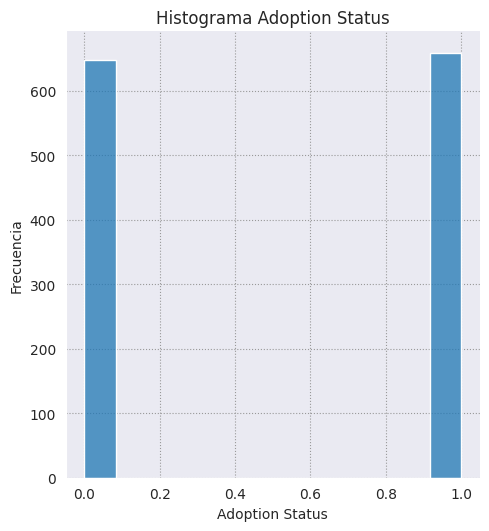

In [9]:
# Se comprueba el resultados final de forma visual
df_adopt_status_balanced = df_pets_balanced.select('adoption_status').rdd.flatMap(lambda x: x).collect()

sns.displot(data=df_adopt_status_balanced, kde=False)
plt.xlabel('Adoption Status')
plt.ylabel('Frecuencia')
plt.title('Histograma Adoption Status')
plt.show()

Ya se cuenta con un set de datos balanceado, a costas de haber perdido los datos. Ahora se procede a analizar los otros atributos con respecto al objectivo predictivo:

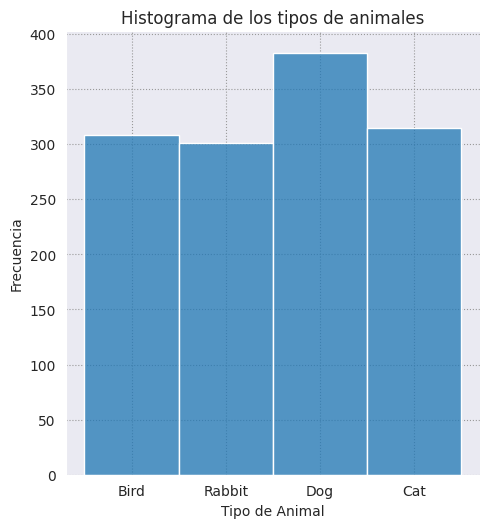

In [10]:
# Tipos de mascotas
petType_data = df_pets_balanced.select('pet_type').rdd.flatMap(lambda x: x).collect()

sns.displot(data=petType_data, kde= False)
plt.xlabel('Tipo de Animal')
plt.ylabel('Frecuencia')
plt.title('Histograma de los tipos de animales')
plt.show()

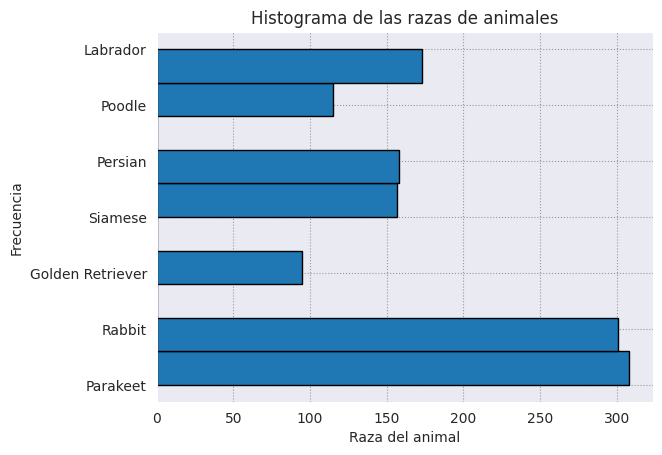

In [11]:
# Razas de los animales
breed_data = df_pets_balanced.select('breed').rdd.flatMap(lambda x: x).collect()

plt.hist(breed_data, orientation='horizontal', edgecolor='black')
plt.xlabel('Raza del animal')
plt.ylabel('Frecuencia')
plt.title('Histograma de las razas de animales')
plt.show()

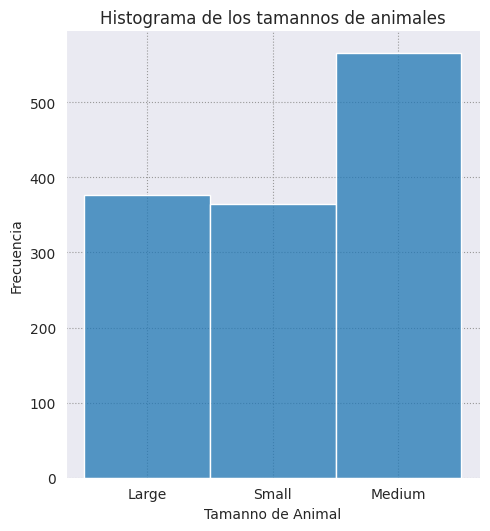

In [12]:
# Tamanno de los animales
size_data = df_pets_balanced.select('size').rdd.flatMap(lambda x: x).collect()

sns.displot(data=size_data, kde= False)
plt.xlabel('Tamanno de Animal')
plt.ylabel('Frecuencia')
plt.title('Histograma de los tamannos de animales')
plt.show()

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


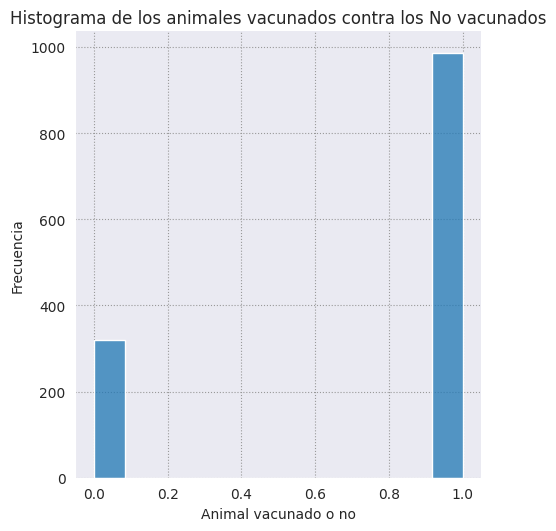

In [13]:
# Vacunados o no?
vaccinated_data = df_pets_balanced.select('vaccinated').rdd.flatMap(lambda x: x).collect()

sns.displot(data=vaccinated_data, kde= False)
plt.xlabel('Animal vacunado o no')
plt.ylabel('Frecuencia')
plt.title('Histograma de los animales vacunados contra los No vacunados')
plt.show()

In [14]:
# Algunas otras metricas estadisticas descriptivas
df_pets_balanced.describe(['weight_kg', 'days_in_shelter', 'adoption_fee']).show()

+-------+------------------+------------------+------------------+
|summary|         weight_kg|   days_in_shelter|      adoption_fee|
+-------+------------------+------------------+------------------+
|  count|              1307|              1307|              1307|
|   mean|15.602388290749676|44.149196633511856| 249.8974751338944|
| stddev| 8.365226099619274|  25.6909108330296|142.55008593384196|
|    min|          1.018198|                 1|                 0|
|    max|         29.995628|                89|               499|
+-------+------------------+------------------+------------------+



Con este analsis, se observa que el set de datos esta bastante saludable. Hay un problema de balance entre los animales vacunados contra los no vacunados, pero el resto de variables categorias se muestran mejor balanceadas, por lo tanto, no se van a eliminar mas datos.

Ahora se procede a almacenar esto en la base de datos:

In [15]:
# Almacenar el conjunto de datos limpio en la base de datos
df_pets_balanced \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3_raw") \
    .save()

### Carga de los datos desde la base de datos y pre-procesado antes de entrenar los modelos de aprendizaje automatico

Se cargan los datos de la base de datos para empezar con el pre-procesado, analisis de correlacion y almacenaje.

In [16]:
# Cargar el conjunto de datos. Esta vez desde la base de datos
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3_raw") \
    .load()

df.show()

+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|pet_type|           breed|age_months|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|
+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|     Cat|         Siamese|        13| Large| 7.252683|      true|           false|              3|         137|         false|           true|
|  Rabbit|          Rabbit|         5| Small|29.078056|      true|           false|             60|         462|         false|           true|
|     Cat|         Persian|       160|Medium|6.3038983|      true|           false|             11|         404|         false|           true|
|     Cat|         Persian|        50|Medium| 28.98293|      true|           false|             13|         109|         false|         

In [17]:
# Indexado de los atributos string
from pyspark.ml.feature import StringIndexer

indexer_pet_type = StringIndexer(inputCol='pet_type', outputCol='pet_type_indexed')
df_indexed = indexer_pet_type.fit(df).transform(df)

indexer_breed = StringIndexer(inputCol='breed', outputCol='breed_indexed')
df_indexed = indexer_breed.fit(df_indexed).transform(df_indexed)

indexer_size = StringIndexer(inputCol='size', outputCol='size_indexed')
df_indexed = indexer_size.fit(df_indexed).transform(df_indexed)

df_indexed.show()

+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+----------------+-------------+------------+
|pet_type|           breed|age_months|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|pet_type_indexed|breed_indexed|size_indexed|
+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+----------------+-------------+------------+
|     Cat|         Siamese|        13| Large| 7.252683|      true|           false|              3|         137|         false|           true|             1.0|          4.0|         1.0|
|  Rabbit|          Rabbit|         5| Small|29.078056|      true|           false|             60|         462|         false|           true|             3.0|          1.0|         2.0|
|     Cat|         Persian|       160|Medium|6.3038983|     

In [18]:
# Haciendo un One Hot Encoding the las columnas indexadas
from pyspark.ml.feature import OneHotEncoder

encoder_pettype = OneHotEncoder(inputCol="pet_type_indexed", outputCol="pet_type_vector")
df_encoded = encoder_pettype.fit(df_indexed).transform(df_indexed)

encoder_breed = OneHotEncoder(inputCol="breed_indexed", outputCol="breed_vector")
df_encoded = encoder_breed.fit(df_encoded).transform(df_encoded)

encoder_size = OneHotEncoder(inputCol="size_indexed", outputCol="size_vector")
df_encoded = encoder_size.fit(df_encoded).transform(df_encoded)

df_encoded.show()

+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+----------------+-------------+------------+---------------+-------------+-------------+
|pet_type|           breed|age_months|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|pet_type_indexed|breed_indexed|size_indexed|pet_type_vector| breed_vector|  size_vector|
+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+----------------+-------------+------------+---------------+-------------+-------------+
|     Cat|         Siamese|        13| Large| 7.252683|      true|           false|              3|         137|         false|           true|             1.0|          4.0|         1.0|  (3,[1],[1.0])|(6,[4],[1.0])|(2,[1],[1.0])|
|  Rabbit|          Rabbit|         5| Small|29.078056|      true|      

In [19]:
# Ensamblando el vector de features
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['pet_type_vector', 
                                       'breed_vector', 
                                       'age_months',
                                       'size_vector', 
                                       'weight_kg', 
                                       'vaccinated', 
                                       'health_condition', 
                                       'days_in_shelter', 
                                       'adoption_fee', 
                                       'previous_owner'], outputCol='features_not_scaled')
df_assembled = assembler.transform(df_encoded)
df_pets_data = df_assembled.select('features_not_scaled', 'adoption_status')
df_pets_data.show()


+--------------------+---------------+
| features_not_scaled|adoption_status|
+--------------------+---------------+
|(18,[1,7,9,11,12,...|           true|
|(18,[4,9,12,13,15...|           true|
|(18,[1,6,9,10,12,...|           true|
|(18,[1,6,9,10,12,...|           true|
|(18,[0,5,9,11,12,...|           true|
|(18,[2,3,9,10,12,...|           true|
|(18,[1,7,9,12,13,...|           true|
|(18,[0,9,10,12,13...|           true|
|(18,[2,3,9,10,12,...|           true|
|(18,[0,5,9,10,12,...|           true|
|(18,[2,3,9,10,12,...|           true|
|(18,[1,6,9,10,12,...|           true|
|(18,[4,9,10,12,13...|           true|
|(18,[0,9,12,13,15...|           true|
|(18,[1,6,9,10,12,...|           true|
|(18,[1,7,9,10,12,...|           true|
|(18,[4,9,10,12,13...|           true|
|(18,[0,5,9,10,12,...|           true|
|(18,[0,8,9,11,12,...|           true|
|(18,[0,5,9,10,12,...|           true|
+--------------------+---------------+
only showing top 20 rows



In [20]:
# Renombrando adoption_status a label, lo cual es compatible con funciones a usar mas adelante
df_pets_data = df_pets_data.withColumnRenamed('adoption_status', 'label')
df_pets_data.show()

+--------------------+-----+
| features_not_scaled|label|
+--------------------+-----+
|(18,[1,7,9,11,12,...| true|
|(18,[4,9,12,13,15...| true|
|(18,[1,6,9,10,12,...| true|
|(18,[1,6,9,10,12,...| true|
|(18,[0,5,9,11,12,...| true|
|(18,[2,3,9,10,12,...| true|
|(18,[1,7,9,12,13,...| true|
|(18,[0,9,10,12,13...| true|
|(18,[2,3,9,10,12,...| true|
|(18,[0,5,9,10,12,...| true|
|(18,[2,3,9,10,12,...| true|
|(18,[1,6,9,10,12,...| true|
|(18,[4,9,10,12,13...| true|
|(18,[0,9,12,13,15...| true|
|(18,[1,6,9,10,12,...| true|
|(18,[1,7,9,10,12,...| true|
|(18,[4,9,10,12,13...| true|
|(18,[0,5,9,10,12,...| true|
|(18,[0,8,9,11,12,...| true|
|(18,[0,5,9,10,12,...| true|
+--------------------+-----+
only showing top 20 rows



In [24]:
# Normalizando los atributos para tener todos los features en la misma escala
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_not_scaled", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_pets_data)
df_pets_data_normalized = scaler_model.transform(df_pets_data)
df_pets_data_normalized.show()

+--------------------+-----+--------------------+
| features_not_scaled|label|            features|
+--------------------+-----+--------------------+
|(18,[1,7,9,11,12,...| true|[-0.6435720817134...|
|(18,[4,9,12,13,15...| true|[-0.6435720817134...|
|(18,[1,6,9,10,12,...| true|[-0.6435720817134...|
|(18,[1,6,9,10,12,...| true|[-0.6435720817134...|
|(18,[0,5,9,11,12,...| true|[1.55263865144448...|
|(18,[2,3,9,10,12,...| true|[-0.6435720817134...|
|(18,[1,7,9,12,13,...| true|[-0.6435720817134...|
|(18,[0,9,10,12,13...| true|[1.55263865144448...|
|(18,[2,3,9,10,12,...| true|[-0.6435720817134...|
|(18,[0,5,9,10,12,...| true|[1.55263865144448...|
|(18,[2,3,9,10,12,...| true|[-0.6435720817134...|
|(18,[1,6,9,10,12,...| true|[-0.6435720817134...|
|(18,[4,9,10,12,13...| true|[-0.6435720817134...|
|(18,[0,9,12,13,15...| true|[1.55263865144448...|
|(18,[1,6,9,10,12,...| true|[-0.6435720817134...|
|(18,[1,7,9,10,12,...| true|[-0.6435720817134...|
|(18,[4,9,10,12,13...| true|[-0.6435720817134...|


24/07/07 23:37:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


<AxesSubplot:>

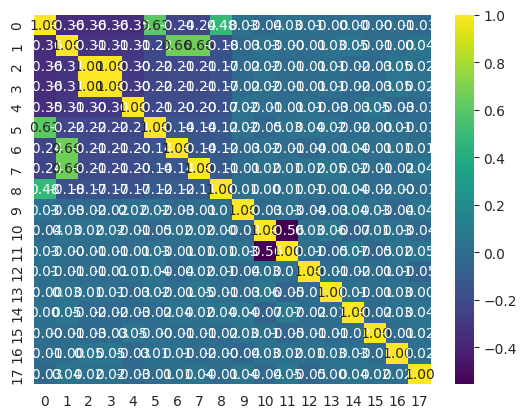

In [25]:
# Calculando las correlaciones para ver si hay atributos correlacionados
from pyspark.ml.stat import Correlation

pearson_matrix = Correlation.corr(df_pets_data_normalized, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

Aunque es dificil de leer por completo, se puede ver que los casos mas graves tienen una correlacion de alrededor de 0.6, lo cual es aceptable y se concluye que el set de datos esta listo para usarse para entrenar y probar un aprendizaje automatico. Antes de eso, se almacenan los datos en la base de datos:

In [30]:
# Primero, descomponer los features en columnas aparte por medio de una funcion que haga split
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, ArrayType

def to_array(v):
    return v.toArray().tolist()

to_array_udf = udf(to_array, ArrayType(FloatType()))

# Se aplica la funcion anterior a la columna con los features normalizados
df_array = df_pets_data_normalized.withColumn("features_array", to_array_udf("features"))
df_features = df_array.select('features_array', 'label')

# Se crean columnas para cada feature
num_features = len(df_features.select("features_array").first()[0])
for i in range(num_features):
    df_features = df_features.withColumn(f"feature_{i}", df_features["features_array"].getItem(i))

# Se crea un dataframe donde se descarten los features en vectores
df_pets_reconstructed = df_features.select('label', *[f"feature_{i}" for i in range(num_features)])
df_pets_reconstructed.show()


+-----+----------+-----------+-----------+-----------+-----------+----------+-----------+----------+-----------+-----------+----------+----------+-------------+----------+-----------+-------------+-----------+----------+
|label| feature_0|  feature_1|  feature_2|  feature_3|  feature_4| feature_5|  feature_6| feature_7|  feature_8|  feature_9|feature_10|feature_11|   feature_12|feature_13| feature_14|   feature_15| feature_16|feature_17|
+-----+----------+-----------+-----------+-----------+-----------+----------+-----------+----------+-----------+-----------+----------+----------+-------------+----------+-----------+-------------+-----------+----------+
| true|-0.6435721|  1.7739214|-0.55504274|-0.55504274|-0.54678684|-0.3904364|-0.37068272| 2.7054088|-0.31048784| -1.4062134|-0.8736408| 1.5729493|  -0.99814457| 0.5691807|-0.42237735|   -1.6017026| -0.7919846|-0.6818289|
| true|-0.6435721|-0.56329155|-0.55504274|-0.55504274|   1.827467|-0.3904364|-0.37068272|-0.3693471|-0.31048784| -1.

In [31]:
# Ya con el set de datos reconstruido, se almacena en la base de datos
df_pets_reconstructed \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .save()

### Carga de los datos desde la base de datos, y desarrollo del aprendizaje automatico

Se cargan los datos de la base de datos para vectorizar los datos y desarrollar los dos modelos de aprendizaje automatico:

In [34]:
# Cargar el conjunto de datos. Esta vez desde la base de datos
df_pets_segmented = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .load()

df_pets_segmented.show()

+-----+----------+-----------+-----------+-----------+-----------+----------+-----------+----------+-----------+-----------+----------+----------+-------------+----------+-----------+-------------+-----------+----------+
|label| feature_0|  feature_1|  feature_2|  feature_3|  feature_4| feature_5|  feature_6| feature_7|  feature_8|  feature_9|feature_10|feature_11|   feature_12|feature_13| feature_14|   feature_15| feature_16|feature_17|
+-----+----------+-----------+-----------+-----------+-----------+----------+-----------+----------+-----------+-----------+----------+----------+-------------+----------+-----------+-------------+-----------+----------+
| true|-0.6435721|  1.7739214|-0.55504274|-0.55504274|-0.54678684|-0.3904364|-0.37068272| 2.7054088|-0.31048784| -1.4062134|-0.8736408| 1.5729493|  -0.99814457| 0.5691807|-0.42237735|   -1.6017026| -0.7919846|-0.6818289|
| true|-0.6435721|-0.56329155|-0.55504274|-0.55504274|   1.827467|-0.3904364|-0.37068272|-0.3693471|-0.31048784| -1.

In [51]:
# Volviendo a generar los vectores de los atributos (recordar que en este ejercicio son 18 atributos)
num_features = 18
feature_columns = [f"feature_{i}" for i in range(num_features)]
assembler_final = VectorAssembler(inputCols=feature_columns, outputCol="features")

df_pets_loaded = assembler_final.transform(df_pets_segmented)

df_pets_loaded = df_pets_loaded.select('features','label')
df_pets_loaded.printSchema()
df_pets_loaded.show()


root
 |-- features: vector (nullable = true)
 |-- label: boolean (nullable = true)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.6435720920562...| true|
|[-0.6435720920562...| true|
|[-0.6435720920562...| true|
|[-0.6435720920562...| true|
|[1.55263864994049...| true|
|[-0.6435720920562...| true|
|[-0.6435720920562...| true|
|[1.55263864994049...| true|
|[-0.6435720920562...| true|
|[1.55263864994049...| true|
|[-0.6435720920562...| true|
|[-0.6435720920562...| true|
|[-0.6435720920562...| true|
|[1.55263864994049...| true|
|[-0.6435720920562...| true|
|[-0.6435720920562...| true|
|[-0.6435720920562...| true|
|[1.55263864994049...| true|
|[1.55263864994049...| true|
|[1.55263864994049...| true|
+--------------------+-----+
only showing top 20 rows



In [54]:
# Convirtiendo la columna label a integer
df_pets_ready = df_pets_loaded.withColumn('label', col('label').cast("integer"))
df_pets_ready.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[1.55263864994049...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[1.55263864994049...|    1|
|[-0.6435720920562...|    1|
|[1.55263864994049...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[1.55263864994049...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[1.55263864994049...|    1|
|[1.55263864994049...|    1|
|[1.55263864994049...|    1|
+--------------------+-----+
only showing top 20 rows



In [55]:
# Antes de empezar con los modelos, se hace un split de 80/20 para prueba y entrenamiento
train_df, test_df = df_pets_ready.randomSplit([0.8, 0.2], seed=12345)

print('Train dataset:')
train_df.show()
print('Test dataset:')
test_df.show()

Train dataset:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.6435720920562...|    0|
|[-0.6435720920562...|    0|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    0|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    0|
+--------------------+-----+
only showing top 20 rows

Test dataset:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.6435720920562...|    1|
|[-0.643572092056

### Primer modelo a probar: Support Vector Machine
Como primer modelo se prueba el SVM, dado que esta optimizado para problemas de categorizacion binaria

In [61]:
# Creando en modelo SVM
from pyspark.ml.classification import LinearSVC

svm_model = LinearSVC(featuresCol='features', labelCol='label')

In [67]:
# Creando el protocolo k-fold con el optimizador de hyperparametros
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Optimizador de hyperparametros
paramGrid = ParamGridBuilder() \
    .addGrid(svm_model.maxIter, [10, 20]) \
    .addGrid(svm_model.regParam, [0.1, 0.01]) \
    .build()

# Protocolo k-fold de 5
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=svm_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [68]:
# Corriendo la validacion cruzada
svm_cvModel = crossval.fit(train_df)

In [69]:
# Haciendo una prediccion y evaluando el Accuracy
predictions = svm_cvModel.transform(test_df)

accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy}")

Test set accuracy = 0.890295358649789
